In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [ ]:
!pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0

In [3]:
import sklearn
print(sklearn.__version__)

1.3.2


In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [5]:
df_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

In [6]:
df_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [7]:
train = pd.merge(df_transaction, df_identity, on='TransactionID', how='left')


# DATA SPLIT

In [8]:
from sklearn.model_selection import train_test_split
#vipovo nan ebi cota sadacaa 

unique_cards = train['card1'].unique()


card_train, card_val_test = train_test_split(unique_cards, test_size=0.4, random_state=42)
card_val, card_test = train_test_split(card_val_test, test_size=0.5, random_state=42)


val = train[train['card1'].isin(card_val)]
test = train[train['card1'].isin(card_test)]
train = train[train['card1'].isin(card_train)]

In [9]:
print(train['isFraud'].mean(), val['isFraud'].mean(), test['isFraud'].mean())

print(len(set(train['card1']) & set(val['card1'])))  
print(len(set(train['card1']) & set(test['card1']))) 

0.03513108235162511 0.03890206572198909 0.03122020767664969
0
0


In [10]:
train_ids = train.pop('TransactionID')
y_train = train.pop('isFraud')
x_train = train

val_ids = val.pop('TransactionID')
y_val = val.pop('isFraud')
x_val = val

test_ids = test.pop('TransactionID')
y_test = test.pop('isFraud')
x_test = test

In [11]:
# Check missingness per column
nan_rates = x_train.isnull().mean().sort_values(ascending=False)
nan_rates

id_24            0.991735
id_25            0.991109
id_21            0.991053
id_08            0.991051
id_07            0.991051
                   ...   
V311             0.000000
V310             0.000000
V309             0.000000
V308             0.000000
TransactionDT    0.000000
Length: 432, dtype: float64

# DATA CLEANING

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class NaNHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.columns_to_keep_ = None
        self.fill_values_ = {}
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        missing_fraction = X_copy.isnull().mean()
        self.columns_to_keep_ = missing_fraction[missing_fraction <= self.threshold].index.tolist()
        for col in self.columns_to_keep_:
            self.fill_values_[col] = X_copy[col].mode().iloc[0] if not X_copy[col].mode().empty else 0
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        X_copy = X_copy[self.columns_to_keep_]
        
        for col, fill_value in self.fill_values_.items():
            X_copy[col] = X_copy[col].fillna(fill_value)
        
        return X_copy


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
class SmartMissingHandler(BaseEstimator, TransformerMixin):
    def __init__(self, nan_threshold=0.8, fraud_ratio_threshold=2.5, verbose=True):
        self.nan_threshold = nan_threshold
        self.fraud_ratio_threshold = fraud_ratio_threshold
        self.verbose = verbose
        self.high_risk_cols_ = None
        self.cols_to_drop_ = None
        self.mean_fraud_rate_ = None
        
    def _print(self, message):
        if self.verbose:
            print(message)
            
    def fit(self, X, y=None):
        """Identify high-risk columns and columns to drop"""
        X = X.copy()
        self._print("\n=== Starting Fit ===")
        
        nan_rates = X.isnull().mean()
        self.cols_to_drop_ = nan_rates[nan_rates >= self.nan_threshold].index.tolist()
        X = X.drop(columns=self.cols_to_drop_)
        
        if y is not None:
            self.mean_fraud_rate_ = y.mean()
            missing_analysis = []
            
            for col in X.columns:
                if X[col].isnull().sum() > 0:
                    fraud_missing = y[X[col].isnull()].mean()
                    fraud_not_missing = y[~X[col].isnull()].mean()
                    ratio = fraud_missing / max(fraud_not_missing, 1e-6)
                    
                    if ratio >= self.fraud_ratio_threshold:
                        missing_analysis.append({
                            'column': col,
                            'fraud_ratio': ratio,
                            'missing_rate': X[col].isnull().mean()
                        })
            
            self.high_risk_cols_ = [x['column'] for x in 
                                  sorted(missing_analysis, 
                                  key=lambda x: -x['fraud_ratio'])]
        
        return self
    
    def transform(self, X):
        """Apply transformations without DataFrame fragmentation"""
        X = X.copy()
        
        if self.cols_to_drop_:
            X = X.drop(columns=self.cols_to_drop_, errors='ignore')
        
        flag_data = {}
        impute_data = {}
        
        for col in (self.high_risk_cols_ or []):
            if col in X.columns:
                flag_data[f'{col}_MISSING'] = X[col].isnull().astype(int)
                if pd.api.types.is_numeric_dtype(X[col]):
                    impute_data[col] = X[col].fillna(-999)
                else:
                    impute_data[col] = X[col].fillna('MISSING_CAT')
        
        other_cols = [c for c in X.columns 
                     if c not in (self.high_risk_cols_ or []) 
                     and X[c].isnull().any()]
        
        for col in other_cols:
            mode_val = X[col].mode()[0] if not X[col].mode().empty else (0 if pd.api.types.is_numeric_dtype(X[col]) else 'MISSING')
            impute_data[col] = X[col].fillna(mode_val)
        
        X = X.assign(**impute_data)
        if flag_data:
            X = pd.concat([X, pd.DataFrame(flag_data, index=X.index)], axis=1)
        
        return X

In [13]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin


class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_columns, one_hot_columns):
        self.ordinal_columns = ordinal_columns
        self.one_hot_columns = one_hot_columns
        self.ordinal_mappings_ = {}
        self.onehot_columns_ = None
        
    def fit(self, X, y=None):
        for col in self.ordinal_columns:
            if col in X.columns:
                unique_vals = X[col].dropna().unique()
                self.ordinal_mappings_[col] = {val: idx for idx, val in enumerate(unique_vals)}
        
        if self.one_hot_columns:
            temp = pd.get_dummies(X[self.one_hot_columns], drop_first=True)
            self.onehot_columns_ = temp.columns.tolist()
            
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        
        for col, mapping in self.ordinal_mappings_.items():
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].map(mapping).fillna(-1)
        
        if self.one_hot_columns and self.onehot_columns_:
            dummies = pd.get_dummies(X_transformed[self.one_hot_columns], drop_first=True)
            
            # Force all expected columns to exist
            for col in self.onehot_columns_:
                if col not in dummies.columns:
                    dummies[col] = 0
            
            # Drop any extra columns (very rare, but safer)
            dummies = dummies[self.onehot_columns_]
            
            X_transformed = pd.concat([
                X_transformed.drop(self.one_hot_columns, axis=1),
                dummies
            ], axis=1)
        
        # Force all object columns to numeric
        for col in X_transformed.columns:
            if X_transformed[col].dtype == object:
                X_transformed[col] = pd.to_numeric(X_transformed[col], errors='coerce').fillna(0)
    
        # SUPER IMPORTANT: Ensure the final column order matches training
        if hasattr(self, "final_columns_"):
            for col in self.final_columns_:
                if col not in X_transformed.columns:
                    X_transformed[col] = 0  # fill missing ones
            X_transformed = X_transformed[self.final_columns_]
        else:
            self.final_columns_ = X_transformed.columns.tolist()
    
        return X_transformed


In [14]:
cat_cols = [col for col in x_train.columns if x_train[col].dtype == 'object']

# Step 2: From those, keep only the ones with <80% NaNs
cat_cols = [col for col in cat_cols if x_train[col].isnull().mean() < 0.8]
num_cols = [col for col in x_train.columns if x_train[col].dtype != 'object']

print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numerical columns ({len(num_cols)}): {num_cols}")

Categorical columns (26): ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
Numerical columns (401): ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 

In [15]:
s = x_train[cat_cols].nunique()
threshold = 3

woe_columns = list(s[s > 3].index)
one_hot_columns = list(s[s <= 3].index)

# FEATURE SELECTION

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class CorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9, method='pearson', verbose=True):
        self.threshold = threshold
        self.method = method
        self.verbose = verbose
        self.cols_to_drop_ = []
        
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        
        num_cols = X.select_dtypes(include=np.number).columns
        X_num = X[num_cols].replace([np.inf, -np.inf], np.nan)
        
        if X_num.isna().any().any():
            raise ValueError("Found NA values in supposedly clean numeric data")
            
        try:
            corr_matrix = X_num.corr(method=self.method).abs()
        except Exception as e:
            print(f"Correlation failed. Checking problematic columns...")
            problematic = []
            for col in num_cols:
                try:
                    X_num[col].astype(float)
                except:
                    problematic.append(col)
            raise ValueError(f"Non-numeric values found in columns: {problematic}")
        
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.cols_to_drop_ = [col for col in upper.columns 
                            if any(upper[col] >= self.threshold)]
        
        if self.verbose:
            print(f"Removing {len(self.cols_to_drop_)} features with {self.method} corr ≥ {self.threshold}")
        return self
    
    def transform(self, X):
        return pd.DataFrame(X).drop(columns=self.cols_to_drop_, errors='ignore')

# TRAINING

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import numpy as np

preprocessor = CustomPreprocessor(ordinal_columns=woe_columns, one_hot_columns=one_hot_columns)

# ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)


X_combined = pd.concat([x_train, x_val], axis=0)
y_combined = np.concatenate([y_train, y_val])
test_fold = np.concatenate([
    -1 * np.ones(len(x_train)),  # training set
     0 * np.ones(len(x_val))     # validation set
])

ps = PredefinedSplit(test_fold)

param_grid = {
    'xgb__max_depth': [5,6]
}


missing_handler = SmartMissingHandler(
    nan_threshold=0.80,          
    fraud_ratio_threshold=2   
)

xgb_model = xgb.XGBClassifier(
    learning_rate=0.05, 
    n_estimators = 100,
    subsample=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    colsample_bytree=0.8,
    min_child_weight=3,  
    gamma=0.1,  
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


full_pipeline = ImbPipeline([
    ('nan_handling', missing_handler),
    ('woe_encoder', preprocessor),
    ('correlation_remover', CorrelationRemover(threshold=0.95)), 
    ('undersample', RandomUnderSampler(random_state=42)),
    ('xgb', xgb_model)
])

grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=ps,  # <- VERY IMPORTANT! Predefined train/val split
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_combined, y_combined)

print("Best parameters:", grid_search.best_params_)
print("Best Validation ROC-AUC: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_train_pred = best_model.predict_proba(x_train)[:, 1]
y_test_pred = best_model.predict_proba(x_test)[:, 1]

from sklearn.metrics import roc_auc_score
# Calculate ROC-AUC
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Test ROC-AUC: {test_auc:.4f}")


Fitting 1 folds for each of 1 candidates, totalling 1 fits

=== Starting Fit ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


Removing 119 features with pearson corr ≥ 0.95
[CV 1/1] END ..................xgb__max_depth=5;, score=0.898 total time= 3.0min

=== Starting Fit ===


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


Removing 156 features with pearson corr ≥ 0.95


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('nan_handling',
                                        SmartMissingHandler(fraud_ratio_threshold=2)),
                                       ('woe_encoder',
                                        CustomPreprocessor(one_hot_columns=['M1',
                                                                            'M2',
                                                                            'M3',
                                                                            'M4',
                                                                            'M5',
                                                                            'M6',
                                                                            'M7',
                                                                            'M8',
                                                                            'M9',
                                                                            'id_12',
                                                                            'id_15',
                                                                            'id_16',
                                                                            'id_28',
                                                                            'id_29',
                                                                            'id_35',
                                                                            'id_36',
                                                                            'id_37',
                                                                            'id_38',
                                                                            'DeviceType'],
                                                           ordinal_column...
                                                      learning_rate=0.05,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=3,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1, param_grid={'xgb__max_depth': [5]}, scoring='roc_auc',
             verbose=3)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
     #('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])


variance_threshold = VarianceThreshold(threshold=0.01)  

xgb_model = XGBClassifier(
    max_depth=5,  
    learning_rate=0.1,  
    n_estimators=1000,  
    subsample=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    colsample_bytree=0.8,
    min_child_weight=3,  
    gamma=0.1, 
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Final pipeline
pipeline = Pipeline([
    ('preprocessing' , preprocessor),
    ('variance_threshold', variance_threshold),
    ('correlation_remover', CorrelationRemover(threshold=0.90)),
    ('xgb', xgb_model)
])
pipeline.fit(x_train, y_train)
y_train_pred = best_model.predict_proba(x_train)[:, 1]
y_test_pred = best_model.predict_proba(x_test)[:, 1]

from sklearn.metrics import roc_auc_score
# Calculate ROC-AUC
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Test ROC-AUC: {test_auc:.4f}")

In [21]:
!pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 27.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 100.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      

In [22]:
import dagshub
dagshub.init(repo_owner='abarb22', repo_name='IEEE-fraud-detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=451f53c5-fecc-4829-abf2-113a31657e06&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=7beb433dd7ef65d2cb1b996015b5a643166b2b2362e1959c72478a79b739d8e8




Output()

Accessing as abarb22

Initialized MLflow to track repo "abarb22/IEEE-fraud-detection"

Repository abarb22/IEEE-fraud-detection initialized!

🏃 View run Preprocessing at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3/runs/451272851b394e0b84ce4165f1fa4f6c
🧪 View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3
🏃 View run LR_FeatureSelection at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3/runs/d4cd3a8bbb304c73bba82fd9dc575cd7
🧪 View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3
🏃 View run LR_CV_Training at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3/runs/61dbec3d54384027a12e23ee813af830
🧪 View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3


2025/04/27 22:49:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGB_FinalModel at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3/runs/14ae6f470e9948f8898dfed3faf8383c
🧪 View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3
🏃 View run XGB_Trial_4 at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3/runs/2c9d1b4e6650457e8e8105b1b0647eaf
🧪 View experiment at: https://dagshub.com/abarb22/IEEE-fraud-detection.mlflow/#/experiments/3


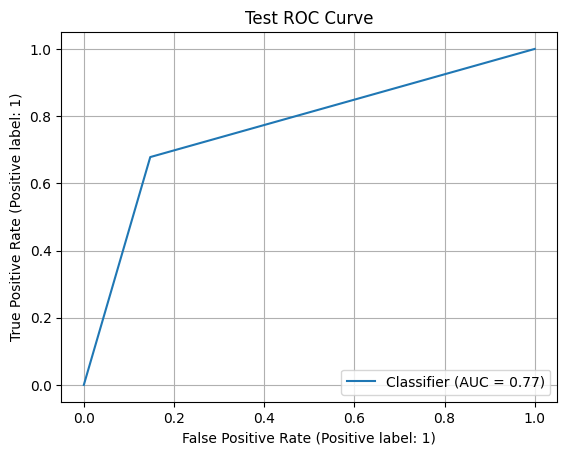

In [28]:
import mlflow
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay, precision_score, recall_score, f1_score
import mlflow.sklearn
import os
import matplotlib.pyplot as plt



mlflow.set_experiment("XGBoost")

with mlflow.start_run(run_name="XGB_Trial_4") as parent_run:
    with mlflow.start_run(run_name="Preprocessing", nested=True):
        mlflow.log_param("categorical_columns", cat_cols)
        mlflow.log_param("nan_handler_threshold", 0.8)
        
        # # Log NaN handling details (how many NaNs were handled)
        # mlflow.log_metric("nans_handled", nan_handler.nans_handled_)

    with mlflow.start_run(run_name="LR_FeatureSelection", nested=True):
        mlflow.log_param("correlation_threshold", 0.95)

    with mlflow.start_run(run_name="LR_CV_Training",  nested=True):
        # Log search space and best hyperparameters
        mlflow.log_params({f"grid__{k}": v for k, v in param_grid.items()})
        mlflow.log_param("model", "XGBoost")
        mlflow.log_param("undersampling", "RandomUnderSampler")
        mlflow.log_param("xgb_learning_rate", 0.05)
        mlflow.log_param("xgb_n_estimators", 100)
        mlflow.log_param("min_child_weight", 3)
        mlflow.log_param("xgb_reg_alpha", 1.0)  # L1 regularization
        mlflow.log_param("xgb_reg_lambda", 1.0)  # L2 regularization
        mlflow.log_param("C_values_grid", param_grid['xgb__max_depth'])
        mlflow.log_metric("val_roc_auc", grid_search.best_score_)
        mlflow.log_param("best_C", grid_search.best_params_)
 

    with mlflow.start_run(run_name="XGB_FinalModel", nested=True):
        # Log final metrics
        mlflow.log_metric("train_roc_auc", train_auc)
        mlflow.log_metric("test_roc_auc", test_auc)
        mlflow.log_metric("val_roc_auc", grid_search.best_score_)

        # Convert probabilities to binary predictions for classification metrics
        y_test_pred = (y_test_pred > 0.5).astype(int)

        # Log precision, recall, F1 scores
        mlflow.log_metric("test_precision", precision_score(y_test, y_test_pred))
        mlflow.log_metric("test_recall", recall_score(y_test, y_test_pred))
        mlflow.log_metric("test_f1", f1_score(y_test, y_test_pred))

        # Log classification report as text
        report = classification_report(y_test, y_test_pred)
        mlflow.log_text(report, "classification_report.txt")

        # Log model
        mlflow.sklearn.log_model(full_pipeline, "final_model")  # Log the entire pipeline

        # Log ROC curve plot
        RocCurveDisplay.from_predictions(y_test, y_test_pred)
        plt.title("Test ROC Curve")
        plt.grid(True)
        plt.savefig("roc_curve.png")
        mlflow.log_artifact("roc_curve.png")
        

